In [1]:
# allow for imports from ../src directory

from os import path as os_path
from os import getcwd
from sys import path as sys_path

sys_path.append(os_path.dirname(getcwd())) 

In [2]:
from dataclasses import dataclass
from dacite import from_dict

import scipy.optimize as optim
import numpy as np
import pandas as pd
import siunits as unit

from scipy import interpolate
from scipy.integrate import trapezoid
from scipy.constants import epsilon_0, elementary_charge, Boltzmann, Avogadro
from src.helper_functions import read_render_markdown_file
from src.plotting import make_simple_plot, fast_plot

from src.model_parameters import set_fluid_parameters
from src.numerical_parameters import set_num_parameters

### Physical constants

1. the electric constant (vacuum permittivity) $\epsilon_0$. Units:  $\textstyle{\rm s^{4}\cdot A^{2}\cdot kg^{-1}\cdot m^{-3}}$ or $\textstyle{\rm C^2 \cdot N^{−1} \cdot m^{−2}}$ or $\textstyle{\rm C \cdot V^{−1} \cdot m^{−1}}$ 

In [3]:
unit.epsilon_0

ampere²·second⁴·meter⁻³·kilogram⁻¹ (A²·s⁴·m⁻³·kg⁻¹), [kg: -1, s: 4, A: 2, m: -3]

In [4]:
epsilon_0

8.8541878128e-12

2. Elementary charge (charge on electron). Units: $\rm C$

In [5]:
unit.c

coulomb (C), [s: 1, A: 1]

In [6]:
elementary_charge

1.602176634e-19

3. Boltzmann constant. Units: $\rm m^2 \cdot kg \cdot s^{-2} \cdot {K}^{-1}$

In [7]:
Boltzmann

1.380649e-23

4. Avogadro's number. Units: $\rm mol^{-1}$

In [8]:
Avogadro

6.02214076e+23

### Singlet model parameters

See Page 62

Dictionary of model parameters

In [9]:
fluid = "kcl"

In [10]:
fluid = set_fluid_parameters("kcl")

In [11]:
fluid

Fluid(name='Potassium Chloride', symbol='KCl', component=['K', 'Cl'], valence=array([ 1., -1.]), temperature=1075.0, concentration=array([19.265, 19.265]), epsilon_r=1.0, n_component=2, n_pair=3, index=1)

In [12]:
valence = fluid.valence
concentration = fluid.concentration
n_pair = fluid.n_pair
n_component = fluid.n_component

Numerical discretisation

In [13]:
z_cutoff = 50.0    # from UI
n_point = 2001     # from UI

In [14]:
discrete = set_num_parameters(n_point, z_cutoff, n_pair)

In [15]:
grid_size = discrete.grid_size
z = discrete.z
z_indices = discrete.z_index

Calculate physical constants

$\beta = 1 / k T$. Units: $\rm m^{-2} \cdot kg^{-1} \cdot s^{2}$

In [17]:
beta = 1.0 / (Boltzmann * fluid.temperature)

In [18]:
epsilon = 4.0 * np.pi * fluid.epsilon_r * epsilon_0  # units same as $\epsilon_0$ (allow for distances in angstrom)

Model potential KCl

In [19]:
read_render_markdown_file("../docs/equation_4_1.md")
read_render_markdown_file("../docs/equation_4_2.md")
read_render_markdown_file("../docs/equation_4_3.md")

$$ u_{ij}(r) = \frac{q_i q_j}{\varepsilon r} + B_{ij} \exp(-\alpha r) + \frac{C_ij}{r^6} + \frac{D_{ij}}{r^8} $$

$$ B_{ij} = \beta_{ij} \, b \exp[\alpha(\sigma_i + \sigma_j)] $$

$$ \beta_{ij} = 1 + \frac{Z_i}{n_i} + \frac{Z_j}{n_j} $$

In [20]:
n_outer_shell = np.array([8., 8.])

In [21]:
def calc_l_index(i, j):
    return i + j    

In [22]:
def calc_beta_pauling(valence, n_outer_shell):
    beta_pauling = np.zeros(n_pair)
    for i in range(n_component):
        for j in range(i, n_component):
            l = calc_l_index(i, j)
            beta_pauling[l] = 1.0 + valence[i] / n_outer_shell[i] + valence[j] / n_outer_shell[j]
    return beta_pauling

In [23]:
beta_pauling = calc_beta_pauling(fluid.valence, n_outer_shell)

In [24]:
alpha = 1.0 / 0.337
b = 0.338e-19
sigma = [1.463, 1.585]

cap_c = np.array([24.3, 48.0, 124.5]) * 1e-19
cap_d = np.array([24.0, 73.0, 250.0]) * 1e-19

In [25]:
def calc_cap_b(beta_pauling, b, alpha, sigma):
    cap_b = np.zeros(n_pair)
    for i in range(n_component):
        for j in range(i, n_component):
            l = calc_l_index(i, j)
            cap_b[l] = beta_pauling[l] * b * np.exp(alpha * (sigma[i] + sigma[j]))
    return cap_b

In [26]:
cap_b = calc_cap_b(beta_pauling, b, alpha, sigma)

In [27]:
#TODO: Fix up choice of c(r) / c*(r) and make sure discretisation matches
# Read in some c(r) -- currently LJ charged spheres

def load_cr():
    CR_PATH = "../pyOZ_bulk_fluid/tests/lj/nrcg-cr.dat.orig"
    cr_df = pd.read_csv(CR_PATH, header=None, delim_whitespace=True)
    cr_df.set_index(0, inplace=True)
    r = cr_df.index.to_numpy()
    cr = cr_df.to_numpy()
    return cr, r

In [28]:
cr_in, r_in = load_cr()

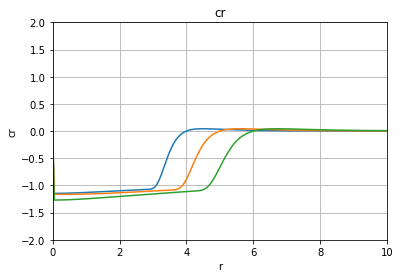

'cr'

In [29]:
make_simple_plot(r_in, cr_in, "r", "cr", "cr", yliml=[-2, 2])

In [30]:

def interpolate_cr(r_in, cr_in):
    cr = np.zeros((n_point, n_pair))
    for l in range(n_pair):
        f = interpolate.interp1d(r_in, cr_in[:, l])
        r = z
        cr[:, l] = f(r)
    return cr, r

In [31]:
cr, r = interpolate_cr(r_in, cr_in)

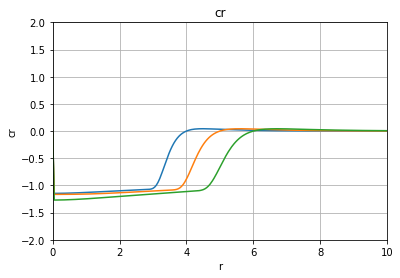

'cr'

In [32]:
make_simple_plot(r, cr, "r", "cr", "cr", yliml=[-2, 2])

In [33]:
def calc_charge(valence):
    return valence * elementary_charge

In [34]:
charge = calc_charge(valence)

In [35]:
r_m = r * 1e-10  # convert distance from Angstrom to m

In [36]:
# Use same discretisation for r as z [Confirm?]

def calc_u(valence, cap_b, alpha, cap_c, cap_d, r):
    u = np.zeros((n_point, n_pair))
    for i in range(n_component):
        for j in range(i, n_component):
            l = calc_l_index(i, j)
            u[1:, l] = (charge[i] * charge[j]) / (r_m[1:] * epsilon) + cap_c[l] / \
                r[1:]**6 + cap_d[l]/r[1:]**8 + \
                cap_b[l] * np.exp(-alpha * r[1:])
    return u


In [37]:
#TODO: Sort out units for this - doesn't make sense currently

u = calc_u(charge, cap_b, alpha, cap_c, cap_d, r)

In [38]:
beta * u

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.06041086e+15,  3.22470124e+15,  1.10423967e+16],
       [ 4.15008872e+12,  1.26120128e+13,  4.31746263e+13],
       ...,
       [ 3.11196680e+00, -3.11196677e+00,  3.11196685e+00],
       [ 3.11041004e+00, -3.11041001e+00,  3.11041008e+00],
       [ 3.10885484e+00, -3.10885481e+00,  3.10885488e+00]])

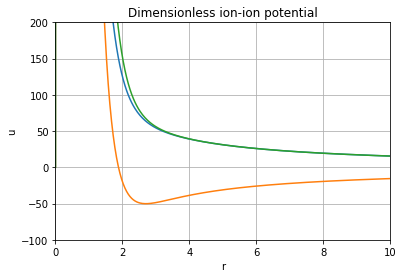

'Dimensionless ion-ion potential'

In [39]:
make_simple_plot(r, beta * u, "r", "u", "Dimensionless ion-ion potential", xliml=[0, 10], yliml=[-100, 200])

In [40]:
psi_0 = 100. / 1000.     # 100 mV (in Volts)  -- get from UI

In [41]:
psi_0

0.1

rho ($\rho$) is the number density which we calculate from the concentration ($c$):

$\rho = c \, \rm mol \, dm^{-3} \cdot dm^{3} / 1.0 \cdot 10^{27} \cdot A^{3} \cdot N_{A} \, mol^{-1}$. Units: $\rm A^{-3}$


In [42]:
def calc_rho(concentration):
    return np.array(concentration) / 1.0e27 * Avogadro

In [43]:
rho = calc_rho(concentration)

In [44]:
rho   # values seem reasonable (compared with those in thesis)

array([0.01160165, 0.01160165])

In [45]:
charge = calc_charge(valence)

In [46]:
def calc_kappa(beta, rho, epsilon):
    return np.sqrt(4.0 * np.pi * beta / epsilon * 1e10 *
    sum(np.multiply(charge**2, rho)))


In [47]:
kappa = calc_kappa(beta, rho, epsilon)

In [48]:
kappa      # similar to thesis value (6.77) page 62 - maybe revisions to physical constants in past 25 years (e.g. 2019 change for $e$)

6.732325586635704

### Wall-ion soft-potential

In [49]:
phiw = np.zeros((n_point, n_component))
hw = np.zeros((n_point, n_component))
tw = np.zeros((n_point, n_component))
# integral_0_z = np.zeros((n_point, n_component))
# integral_z_inf = np.zeros((n_point, n_component))

In [50]:
# same for both ions

def calc_phiw(z, n_component):
    capital_a = 16.274e-19 # joules
    wall_d = 2.97  # inverse Angstrom
    for i in range(n_component):
        phiw[:, i] = np.exp(-wall_d * z) * capital_a * (wall_d * z + 2)
    return phiw


In [51]:
beta_phiw = beta * calc_phiw(z, n_component)

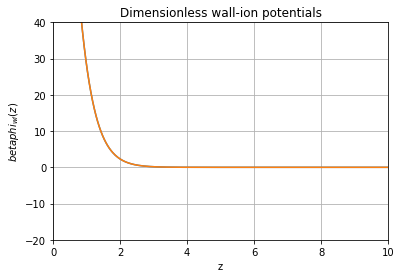

'Dimensionless wall-ion potentials'

In [52]:
make_simple_plot(z, beta_phiw, "z", "$beta phi_{wi}(z)$", "Dimensionless wall-ion potentials")

This dimensionless plot matches well with Figure 4.1(b) of thesis.

### Bulk fluid inputs

Not sure what to do here -- maybe run pyOZ for ionic fluid and try using c_{ij}(r) from this as an approximation?

In [53]:
read_render_markdown_file("../docs/equation_3_4.md")

$$ f_{ij}^{(n)}(z) = \int_z^{\infty} dr r^n c_{ij}^{*} $$

In [54]:
# Assume all of the moments of the short-ranged bulk direct correlation functions to be zero initially

f1 = np.zeros((n_point, n_pair))
f2 = np.zeros((n_point, n_pair))
c_short = np.zeros((n_point, n_pair))

In [55]:
# for now assume c*(r) = c(r)

c_short = cr

In [56]:
charge_pair = np.array([1, -1, 1]) * elementary_charge

In [57]:
read_render_markdown_file("../docs/equation_3_5.md")

$$ c_{ij}^*(r) = c_{ij}(r) + \beta q_i q_j / (\varepsilon r) $$

In [58]:
#TODO: Too big?

beta * charge_pair[0] * elementary_charge * elementary_charge / (epsilon * 1e-10) 

2.4904672803694033e-17

In [59]:
c_short

array([[ 0.     ,  0.     ,  0.     ],
       [-0.57316, -0.58233, -0.63448],
       [-1.14632, -1.16466, -1.26896],
       ...,
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ]])

In [60]:
# skip r = 0 to avoid divide by 0 error

#for l in range(n_pair):
#    c_short[1:, l] = c_short[1:, l]  + beta * charge_pair[l] * 1e-10 / (epsilon * r[1:])
    

In [61]:
c_short

array([[ 0.     ,  0.     ,  0.     ],
       [-0.57316, -0.58233, -0.63448],
       [-1.14632, -1.16466, -1.26896],
       ...,
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ]])

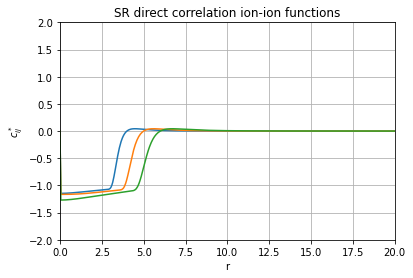

'SR direct correlation ion-ion functions'

In [62]:
make_simple_plot(r, c_short, "r", "$c_{ij}^*$", "SR direct correlation ion-ion functions", xliml=[0, 20], yliml=[-2, 2])

In [63]:
def integral_z_infty_dr_r_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f1[k, ij] = trapezoid(y=z[:k] * c_short[k, ij], x=z[:k])
    return f1

In [64]:
def integral_z_infty_dr_r2_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f2[k, ij] = trapezoid(y=z[:k] * z[:k] * c_short[k, ij], x=z[:k])
    return f2

In [65]:
f1 = integral_z_infty_dr_r_c_short(c_short, z)

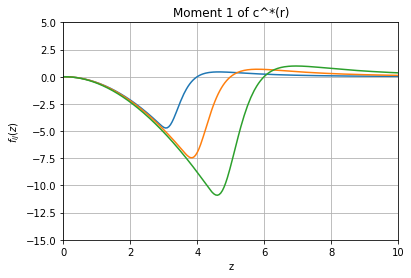

'Moment 1 of c^*(r)'

In [66]:
make_simple_plot(z, f1, "z", "$f_{ij}(z)$", "Moment 1 of c^*(r)", yliml=[-15, 5])

In [67]:
f2 = integral_z_infty_dr_r2_c_short(c_short, z)

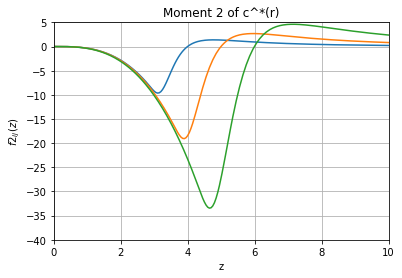

'Moment 2 of c^*(r)'

In [68]:
make_simple_plot(z, f2, "z", "$f2_{ij}(z)$", "Moment 2 of c^*(r)", yliml=[-40, 5])

Initial guess for solution $t_{wi}(z)$ - solving $F(t(z)) = 0$

In [69]:
tw_initial = np.zeros((n_point, n_component))    # initial guess of zero - maybe should be \beta \phi

# tw = beta_phiw_i

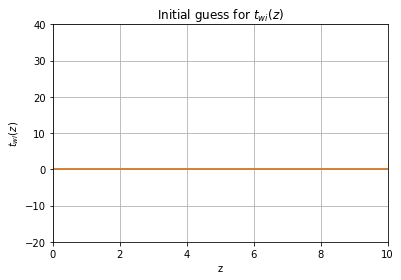

'Initial guess for $t_{wi}(z)$'

In [70]:
make_simple_plot(z, tw_initial, "z", "$t_{wi}(z)$", "Initial guess for $t_{wi}(z)$")

In [71]:
def calc_hw(tw, beta_phiw):
    for i in range(n_component):
        hw[:, i] = np.exp(tw[:, i] - beta_phiw[:, i]) - 1.0
    return hw


In [72]:
hw = calc_hw(tw_initial, beta_phiw)

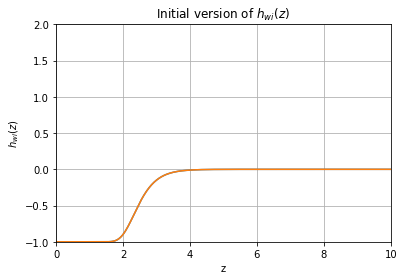

'Initial version of $h_{wi}(z)$'

In [73]:
make_simple_plot(z, hw, "z", "$h_{wi}(z)$", "Initial version of $h_{wi}(z)$", yliml=[-1, 2])

In [74]:
beta_psi =  beta * psi_0

In [75]:
beta_psi

6.737646991665042e+18

In [76]:
np.log(np.exp(beta_phiw))

array([[219.29693428, 219.29693428],
       [211.16274464, 211.16274464],
       [203.06973038, 203.06973038],
       ...,
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ]])

In [77]:
read_render_markdown_file("../docs/equation_5_9.md")
read_render_markdown_file("../docs/equation_5_9b.md")

$$ \large t_{wi}(z) = \ln \left[ g_{wi}(z) \exp(\beta \phi_{wi}(z)) \right] $$

$$ t_{wi}(z) ~=~ - \beta q_i \psi_0 + 2 \pi \sum_{j} \bar{\rho_j} \left \{  z f_{ij}^{(1)}(z) - f_{ij}^{(2)}(z) - \left( 2 \beta q_i q_j / \varepsilon \right ) \left(  \int_0^z dt t h_{wj}(t) + z \int_{z}^{\infty} dt h_{wj}(t) \right) + \int_0^{\infty} dt h_{wj}(t) f_{ij}^{(1)} ( | z - t | ) \right \} $$

In [78]:
integral_0_z = np.zeros((n_point, n_component))
integral_z_infty = np.zeros((n_point, n_component))

In [79]:
beta_psi * charge[0]

1.0794900578186124

In [80]:
2.0 * beta * charge[0] * charge[0] / epsilon * 1e10

310.8854826014649

#### TODO: Check limits to make sure treating end points of arrays appropriately



In [81]:
beta_psi_charge = np.zeros((n_point, n_component))

In [82]:
def calc_tw_term_by_term(tw_in, beta_psi, rho, f1, f2, z):
    hw = calc_hw(tw_in, beta_phiw)

    for i in range(n_component):
        for k in range(n_point):
            integral_0_z[k, i] = trapezoid(y=hw[:k, i], x=z[:k])
            integral_z_infty[k, i] = trapezoid(y=z[k:] * hw[k:, i], x=z[k:])

    for i in range(n_component):
        beta_psi_charge[:, i] = -beta_psi * charge[i]
        for k in range(n_point):
            z_minus_t = np.flip(z_indices[:k])
            t_minus_z = z_indices[k:] - k
            for j in range(n_component):
                l = calc_l_index(i, j)
                tw[k, i] = beta_psi_charge[k, i] + 2.0 * np.pi * rho[j] * (z[k] * f1[k, l] - f2[k, l])
                # +
                #                                               (2.0 * beta * charge[i] * charge[j] / epsilon) *
                #                                               (integral_z_infty[k, j] + z[k] * integral_0_z[k, j])
                #                                               + trapezoid(y=hw[:k, j] * f1[z_minus_t, l])
                #                                               + trapezoid(y=hw[k:, j] * f1[t_minus_z, l]))
    return hw, integral_0_z, integral_z_infty, beta_psi_charge, z_minus_t, t_minus_z, tw, k

In [83]:
hw_initial, integral_0_z, integral_z_infty, beta_psi_charge, z_minus_t, t_minus_z, tw, k = calc_tw_term_by_term(tw_initial, beta_psi, rho, f1, f2, z)

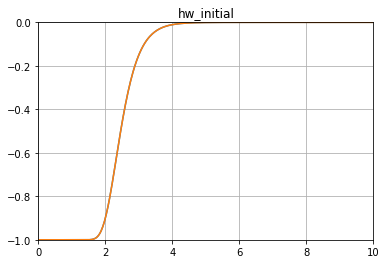

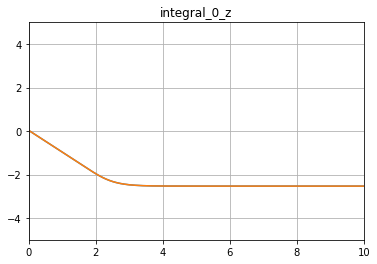

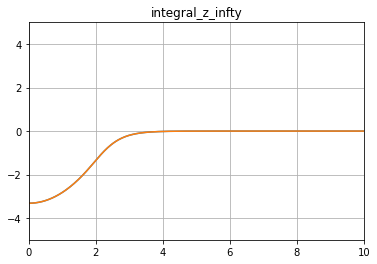

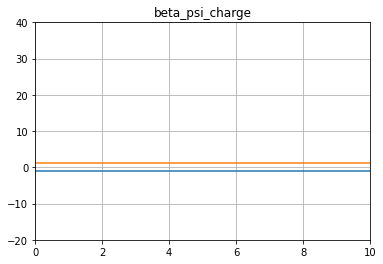

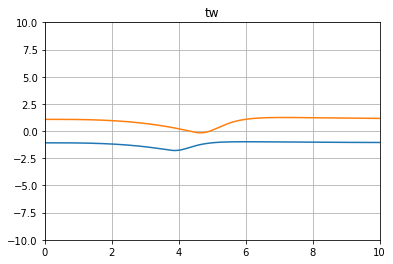

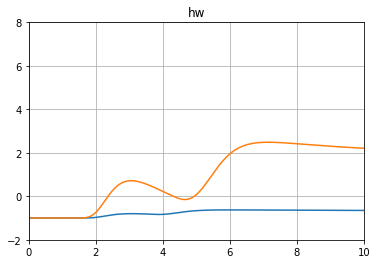

'hw'

In [84]:
make_simple_plot(z, hw_initial, title="hw_initial", yliml=[-1, 0])
make_simple_plot(z, integral_0_z, title="integral_0_z", yliml=[-5, 5])
make_simple_plot(z, integral_z_infty, title="integral_z_infty", yliml=[-5, 5])
make_simple_plot(z, beta_psi_charge, title="beta_psi_charge")
make_simple_plot(z, tw, title="tw", yliml=[-10, 10])
make_simple_plot(z, calc_hw(tw, beta_phiw), title="hw", yliml=[-2, 8])

In [85]:
def calc_tw(tw_in, beta_psi, rho, f1, f2, z):
    hw = calc_hw(tw_in, beta_phiw)

    for i in range(n_component):
        for k in range(n_point):
            integral_0_z[k, i] = trapezoid(y=hw[:k, i], x=z[:k])
            integral_z_infty[k, i] = trapezoid(y=z[k:] * hw[k:, i], x=z[k:])

    for i in range(n_component):
        beta_psi_charge[:, i] = -beta_psi * charge[i]
        for k in range(n_point):
            z_minus_t = np.flip(z_indices[:k])
            t_minus_z = z_indices[k:] - k
            for j in range(n_component):
                l = calc_l_index(i, j)
                tw[k, i] = beta_psi_charge[k, i] + 2.0 * np.pi * rho[j] * (z[k] * f1[k, l] - f2[k, l] +
                                                              (2.0 * beta * charge[i] * charge[j] / epsilon / 1e10) *
                                                              (integral_z_infty[k, j] + z[k] * integral_0_z[k, j])
                                                              + trapezoid(y=hw[:k, j] * f1[z_minus_t, l])
                                                              + trapezoid(y=hw[k:, j] * f1[t_minus_z, l]))
    return tw


In [86]:
# print("Notebook execution aborted.")
# assert(False)

# STOP_CALCULATION

### Numerical solver: Newton-GMRES

In [87]:
# this should equal 0 (as t(z) converges to solution)

def opt_func(tw):
    return tw - calc_tw(tw, beta_psi, rho, f1, f2, z)

In [88]:
tolerance = 1e-9

In [89]:
# Documentation: https://scipy.github.io/devdocs/reference/optimize.root-krylov.html

solution = optim.root(opt_func, tw_initial, method="krylov", jac=None,
                      tol=tolerance, callback=None, options={"disp": True, "maxiter": 20})


0:  |F(x)| = 55.6519; step 0.0511985
1:  |F(x)| = 52.697; step 0.0828371
2:  |F(x)| = 46.9173; step 0.167511
3:  |F(x)| = 30.5482; step 0.493538
4:  |F(x)| = 29.6365; step 1
5:  |F(x)| = 25.1308; step 1
6:  |F(x)| = 22.0025; step 0.480716
7:  |F(x)| = 22.23; step 1
8:  |F(x)| = 21.7994; step 0.499312
9:  |F(x)| = 22.777; step 1
10:  |F(x)| = 21.8745; step 1
11:  |F(x)| = 21.9568; step 1
12:  |F(x)| = 21.9067; step 0.0175735
13:  |F(x)| = 21.8426; step 0.0212153
14:  |F(x)| = 21.765; step 0.0241841
15:  |F(x)| = 21.6618; step 0.0281649
16:  |F(x)| = 21.4678; step 0.0524962
17:  |F(x)| = 21.5483; step 0.0850134
18:  |F(x)| = 21.5883; step 0.0717981
19:  |F(x)| = 21.5609; step 0.0353577


In [90]:
tw_solution = solution.x

In [91]:
solution.nit

20

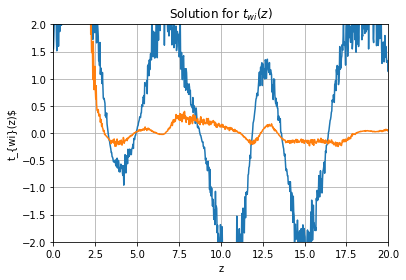

'Solution for $t_{wi}(z)$'

In [92]:
make_simple_plot(z, tw_solution, "z", "t_{wi}(z)$", "Solution for $t_{wi}(z)$", xliml=[0, 20], yliml=[-2, 2])

In [93]:
hw_solution = calc_hw(tw_solution, beta_phiw)

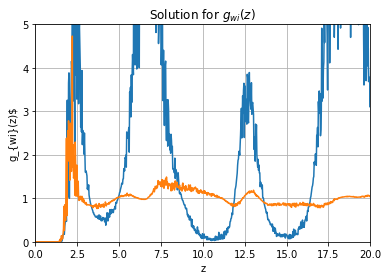

'Solution for $g_{wi}(z)$'

In [94]:
make_simple_plot(z, hw_solution+1, "z", "g_{wi}(z)$", "Solution for $g_{wi}(z)$", xliml=[0, 20], yliml=[0, 5])

In [95]:
opt_func(tw)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])